In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
import json
import os
import sys
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from random import choice

In [6]:
df = pd.read_excel("datos_casas_apuestas.xlsx")

In [9]:
# Cambiamos los nombres de algunas variables, dropeamos los valores vacios y ordenamos por fecha
# La fecha va de la más antigua a la más nueva
df.rename(columns={'local_total': 'score_home',"total_visit":"score_away"}, inplace=True)
df.rename(columns={'local_name': 'team_home',"visit_name":"team_away"}, inplace=True)
df = df.dropna(subset=['score_away'])
df = df.dropna(subset=['score_home'])
df = df.dropna(subset=["betpractice_match_odds_the_draw_ft"])
df = df.dropna(subset=["betting_house_match_odds_the_draw_ft"])
df = df.sort_values(by="date",ignore_index=True)


In [10]:
df

,id,date,team_home,team_away,score_home,score_away,betpractice_match_odds_team1_ft,betting_house_match_odds_team1_ft,betpractice_match_odds_the_draw_ft,betting_house_match_odds_the_draw_ft,...,betpractice_half_time_full_time_draw_draw,betting_house_half_time_full_time_draw_draw,betpractice_half_time_full_time_draw_team2,betting_house_half_time_full_time_draw_team2,betpractice_half_time_full_time_team2_team1,betting_house_half_time_full_time_team2_team1,betpractice_half_time_full_time_team2_draw,betting_house_half_time_full_time_team2_draw,betpractice_half_time_full_time_team2_team2,betting_house_half_time_full_time_team2_team2
0,ENG-PRE,2023-01-02,Luton Town,Chelsea,2.0,3.0,2.18,5.50,5.29,4.58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENG-WAL,2023-01-02,Whitehawk,Billericay Town,0.0,1.0,2.31,3.15,3.36,3.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ENG-WAL,2023-01-02,Kingstonian,Wingate & Finchley,1.0,2.0,3.00,2.68,5.45,3.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,WLS-PLG,2023-01-02,Barry Town United,Cardiff MU,0.0,0.0,2.62,2.47,4.25,3.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,WLS-PLG,2023-01-02,Bala Town,Newtown,2.0,1.0,2.23,2.40,4.45,3.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37483,ENG-LG1,2023-12-29,Exeter City,Portsmouth,0.0,0.0,3.19,4.58,3.72,3.74,...,5.15,5.45,7.44,4.50,NaN,43.0,22.33,15.5,3.53,2.56
37484,ITA-SRA,2023-12-29,Genoa,Inter,1.0,1.0,3.50,6.27,5.00,3.85,...,17.50,4.90,5.00,4.05,NaN,55.0,11.67,18.5,3.18,2.39
37485,ITA-SRA,2023-12-29,Lazio,Frosinone,3.0,1.0,1.67,1.67,4.38,4.11,...,7.00,5.60,35.00,11.70,17.50,26.0,35.00,17.5,8.75,9.70
37486,ENG-CHA,2023-12-29,Cardiff City,Leicester City,0.0,2.0,3.62,5.76,4.27,4.10,...,7.83,5.85,4.70,4.25,NaN,46.0,15.67,17.0,3.92,2.27


In [11]:
# Estadisticas simples, ver si jugar en casa afecta
home_win = 0
away_win = 0
draw = 0
for i in range(len(df)):
    if df.iloc[i]["score_home"] > df.iloc[i]["score_away"]:
        home_win +=1
    elif df.iloc[i]["score_away"] > df.iloc[i]["score_home"]:
        away_win +=1
    elif df.iloc[i]["score_away"] == df.iloc[i]["score_home"]:
        draw +=1

total = len(df)
home_win_percentage = home_win/total
away_win_percentage = away_win/total
draw_perentage = draw/total

In [12]:
print(home_win_percentage)
print(away_win_percentage)
print(draw_perentage)

0.447663252240717
0.2962548015364917
0.2560819462227913


In [16]:
# Esta funcion esta optimizada para funcionar con JobLib en paralelo
# Puesto que así es mucho más rápido.
def search_features(i, df, last_games):
    # W = home_win, D = draw, L = home_lose
    team_home = df.iloc[i]["team_home"]
    team_away = df.iloc[i]["team_away"]
    home_search = last_games
    away_search = last_games
    # W = win, D = draw, L = lose
    info_home = []
    info_away = []
    # Para hacer la busqueda más eficiente, solo buscamos en los partidos que estos equipos juegan
    df_match1 = df[df["team_home"] == team_home]
    df_match2 = df[df["team_away"] == team_home]
    df_match3 = df[df["team_home"] == team_away]
    df_match4 = df[df["team_away"] == team_away]
    df_match_index = sorted(list(set(df_match1.index) | set(df_match2.index) | set(
        df_match3.index) | set(df_match4.index)), reverse=True)
    # iteramos solo en los index
    for j in df_match_index:
        if away_search == 0 and home_search == 0:
            if df.iloc[i]["score_home"] > df.iloc[i]["score_away"]:
                result = "W"
            elif df.iloc[i]["score_home"] == df.iloc[i]["score_away"]:
                result = "D"
            elif df.iloc[i]["score_home"] < df.iloc[i]["score_away"]:
                result = "L"
            return info_home, info_away, result
        # Buscamos los partidos anteriores del equipo de CASA
        # Como i es el partido actual y j el que estamos buscando,
        # si  i<j, entonces estamos en un partido del futuro (por lo que queremos lo contrario)
        if home_search > 0 and i-j > 0:
            if team_home == df.iloc[j]["team_home"]:
                home_search -= 1
                # Casa gana
                if df.iloc[j]["score_home"] > df.iloc[j]["score_away"]:
                    info_home.append("W")
                # Casa pierde
                elif df.iloc[j]["score_home"] < df.iloc[j]["score_away"]:
                    info_home.append("L")
                # Casa empata
                elif df.iloc[j]["score_home"] == df.iloc[j]["score_away"]:
                    info_home.append("D")
            elif team_home == df.iloc[j]["team_away"]:
                home_search -= 1
                # Visita gana
                if df.iloc[j]["score_away"] > df.iloc[j]["score_home"]:
                    info_home.append("W")
                # Visita pierde
                elif df.iloc[j]["score_away"] < df.iloc[j]["score_home"]:
                    info_home.append("L")
                # Visita empata
                elif df.iloc[j]["score_away"] == df.iloc[j]["score_home"]:
                    info_home.append("D")

        # Buscamos los partidos anteriores del equipo de VISITA
        if away_search > 0 and i-j > 0:
            if team_away == df.iloc[j]["team_home"]:
                away_search -= 1
                # Casa gana
                if df.iloc[j]["score_home"] > df.iloc[j]["score_away"]:
                    info_away.append("W")
                # Casa pierde
                elif df.iloc[j]["score_home"] < df.iloc[j]["score_away"]:
                    info_away.append("L")
                # Casa empata
                elif df.iloc[j]["score_home"] == df.iloc[j]["score_away"]:
                    info_away.append("D")
            elif team_away == df.iloc[j]["team_away"]:
                away_search -= 1
                # Visita gana
                if df.iloc[j]["score_away"] > df.iloc[j]["score_home"]:
                    info_away.append("W")
                # Visita pierde
                elif df.iloc[j]["score_away"] < df.iloc[j]["score_home"]:
                    info_away.append("L")
                # Visita empata
                elif df.iloc[j]["score_away"] == df.iloc[j]["score_home"]:
                    info_away.append("D")

In [17]:
# Last games = Juegos pasados a tener en cuenta
# Num_trabajadores = Trabajadores en paralelo (usar -1 para todos los posibles)
# Se demora un par de minutos
last_games = 15
num_trabajadores = -1
resultados = Parallel(n_jobs=num_trabajadores,verbose=10)(
    delayed(search_features)(i, df, last_games) for i in range(len(df)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.18235236780678946s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10540413856506348s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.13031840324401855s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    1.2s
[Parallel(n_job

In [18]:
# X = Input Features
# Y = Outputs
# Index = Para identificar donde están en el dataframe original

# Los valores de X son tal que :
# [home_wins, home_draws, home_lose,
# away_wins, away_draws, away_lose,
# *[home_match1_win/lose/draw],*[home_match2_win/lose/draw],...*[home_matchN_win/lose/draw],
# *[away_match1_win/lose/draw],*[away_match2_win/lose/draw],...*[away_matchN_win/lose/draw]]
# Donde 
# *[XXX_match1_win/lose/draw] = *[1,0,0] = win
# *[XXX_match1_win/lose/draw] = *[0,1,0] = draw
# *[XXX_match1_win/lose/draw] = *[0,0,1] = lose
X = []
Y = []
index = []
for i in range(len(resultados)):
    if resultados[i] != None:
        index.append(i)
        
        streak_home = resultados[i][0]
        streak_away = resultados[i][1]
        result = resultados[i][2]

        # Suma de resultados

        home_wins = streak_home.count("W")
        home_draws = streak_home.count("D")
        home_lose = streak_home.count("L")

        away_wins = streak_away.count("W")
        away_draws = streak_away.count("D")
        away_lose = streak_away.count("L")

        features =[home_wins, home_draws, home_lose,
                  away_wins, away_draws, away_lose]

        # Con factor temporal
        # features = []
        for match in streak_home:
            if match == "W":
                features.extend([1,0,0])
            elif match == "D":
                features.extend([0,1,0])
            elif match == "L":
                features.extend([0,0,1])

        for match in streak_away:
            if match == "W":
                features.extend([1,0,0])
            elif match == "D":
                features.extend([0,1,0])
            elif match == "L":
                features.extend([0,0,1])

        X.append(features)

        if result == "W":
            Y.append([1, 0, 0])
        elif result == "D":
            Y.append([0, 1, 0])
        elif result == "L":
            Y.append([0, 0, 1])



In [19]:
len(X[0])

96

In [20]:
len(index)

17306

In [23]:
import random
from copy import deepcopy
# Pruebas con random, para ver si esta todo bien
copy_X = deepcopy(X)
random.shuffle(copy_X)
copy_Y = deepcopy(Y)
random.shuffle(copy_Y)

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(
    X, Y, index, test_size=0.2)

drop = 0.5
model = model = models.Sequential()
model.add(layers.InputLayer(input_shape=(len(X[0]),)))
# model.add(layers.Dense(32, activation='relu'),)
# model.add(layers.Dropout(drop))
model.add(layers.Dense(3, activation='softmax'))
# # Compilamos el modelo
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.1, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer="adam", metrics=['categorical_accuracy',])

# # Entrenamos el modelo
history = model.fit(X_train, y_train, verbose=1, epochs=100,
                    validation_data=(X_test, y_test))

Epoch 1/100
433/433 [==============================] - 1s 2ms/step - loss: 1.1154 - categorical_accuracy: 0.4344 - val_loss: 1.0733 - val_categorical_accuracy: 0.4408
Epoch 2/100
433/433 [==============================] - 0s 729us/step - loss: 1.0440 - categorical_accuracy: 0.4753 - val_loss: 1.0513 - val_categorical_accuracy: 0.4694
Epoch 3/100
433/433 [==============================] - 0s 732us/step - loss: 1.0346 - categorical_accuracy: 0.4857 - val_loss: 1.0482 - val_categorical_accuracy: 0.4737
Epoch 4/100
433/433 [==============================] - 0s 735us/step - loss: 1.0332 - categorical_accuracy: 0.4828 - val_loss: 1.0500 - val_categorical_accuracy: 0.4653
Epoch 5/100
433/433 [==============================] - 0s 734us/step - loss: 1.0331 - categorical_accuracy: 0.4842 - val_loss: 1.0490 - val_categorical_accuracy: 0.4723
Epoch 6/100
433/433 [==============================] - 0s 730us/step - loss: 1.0334 - categorical_accuracy: 0.4827 - val_loss: 1.0581 - val_categorical_accur

109/109 [==============================] - 0s 475us/step
Matriz de Confusión:


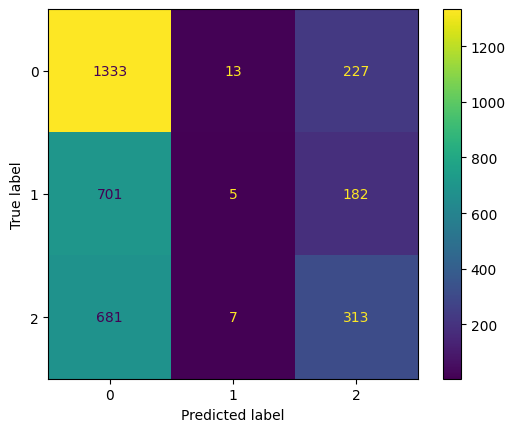

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


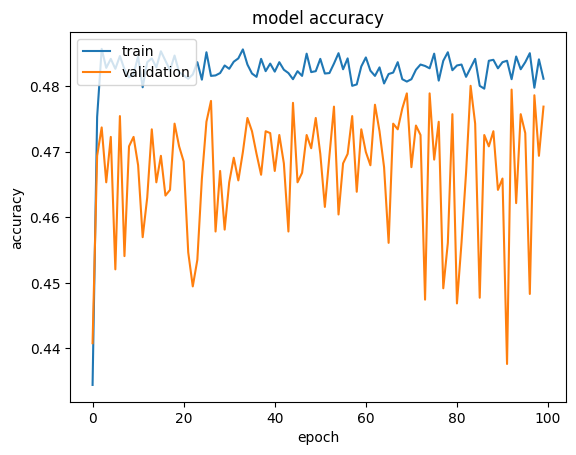

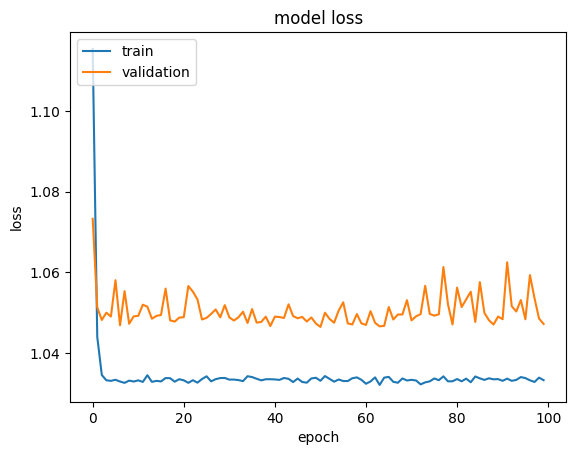

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
y_prob = model.predict(X_test)
y_test_metrics = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_prob, axis=1)


# Matriz de confusión
conf_matrix = confusion_matrix(y_test_metrics, y_pred)
print('Matriz de Confusión:')
ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [29]:
print(classification_report(y_test_metrics, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.85      0.62      1573
           1       0.20      0.01      0.01       888
           2       0.43      0.31      0.36      1001

    accuracy                           0.48      3462
   macro avg       0.37      0.39      0.33      3462
weighted avg       0.40      0.48      0.39      3462



In [31]:
# Pruebas con la casa de apuestas de BetPractice
pred = model.predict(X_test)
mejor_esperanza = []
mejor_resultado = []
random = []
k = 0
total = 0
for i in index_test:
    win_home = df.loc[i]["betpractice_match_odds_team1_ft"]*pred[k][0]
    draw = df.loc[i]["betpractice_match_odds_the_draw_ft"]*pred[k][1]
    win_away = df.loc[i]["betpractice_match_odds_team2_ft"]*pred[k][2]
    arg_max = np.argmax([win_home, draw, win_away])
    if draw > 0 and win_home > 0 and win_away > 0:
        total += 1
        # Mejor esperanza
        if y_test[k] == [1, 0, 0] and arg_max == 0:
            mejor_esperanza.append(df.loc[i]["betpractice_match_odds_team1_ft"])
        elif y_test[k] == [0, 1, 0] and arg_max == 1:
            mejor_esperanza.append(df.loc[i]["betpractice_match_odds_the_draw_ft"])
        elif y_test[k] == [0, 0, 1] and arg_max == 2:
            mejor_esperanza.append(df.loc[i]["betpractice_match_odds_team2_ft"])
        # Mejor resultado
        if y_test[k] == [1, 0, 0] and np.argmax(pred[k]) == 0:
            mejor_resultado.append(df.loc[i]["betpractice_match_odds_team1_ft"])
        elif y_test[k] == [0, 1, 0] and np.argmax(pred[k]) == 1:
            mejor_resultado.append(df.loc[i]["betpractice_match_odds_the_draw_ft"])
        elif y_test[k] == [0, 0, 1] and np.argmax(pred[k]) == 2:
            mejor_resultado.append(df.loc[i]["betpractice_match_odds_team2_ft"])
        # Random
        arg_max = choice([0, 1, 2]) 
        if y_test[k] == [1, 0, 0] and arg_max == 0:
            random.append(df.loc[i]["betpractice_match_odds_team1_ft"])
        elif y_test[k] == [0, 1, 0] and arg_max == 1:
            random.append(df.loc[i]["betpractice_match_odds_the_draw_ft"])
        elif y_test[k] == [0, 0, 1] and arg_max == 2:
            random.append(df.loc[i]["betpractice_match_odds_team2_ft"])
    k += 1
print("Rendimiento Mejor Esperanza")
print(sum(mejor_esperanza)/total)
print("Rendimiento Mejor Resultado")
print(sum(mejor_resultado)/total)
print("Rendimiento Random")
print(sum(random)/total)
print("Acertados Mejor Esperanza")
print(len(mejor_esperanza)/total)
print("Acertados Mejor Resultado")
print(len(mejor_resultado)/total)
print("Acertados Random")
print(len(random)/total)

109/109 [==============================] - 0s 456us/step
Rendimiento Mejor Esperanza
1.2212632197414826
Rendimiento Mejor Resultado
1.0995417156286733
Rendimiento Random
0.9895064629847244
Acertados Mejor Esperanza
0.33783783783783783
Acertados Mejor Resultado
0.4791421856639248
Acertados Random
0.3199177438307873


In [32]:
pred = model.predict(X_test)
mejor_esperanza = []
mejor_resultado = []
random = []
k = 0
total = 0
for i in index_test:
    win_home = df.loc[i]["betting_house_match_odds_team1_ft"]*pred[k][0]
    draw = df.loc[i]["betting_house_match_odds_the_draw_ft"]*pred[k][1]
    win_away = df.loc[i]["betting_house_match_odds_team2_ft"]*pred[k][2]
    arg_max = np.argmax([win_home, draw, win_away])
    if draw > 0:
        total += 1
        # Mejor esperanza
        if y_test[k] == [1, 0, 0] and arg_max == 0:
            mejor_esperanza.append(
                df.loc[i]["betting_house_match_odds_team1_ft"])
        elif y_test[k] == [0, 1, 0] and arg_max == 1:
            mejor_esperanza.append(
                df.loc[i]["betting_house_match_odds_the_draw_ft"])
        elif y_test[k] == [0, 0, 1] and arg_max == 2:
            mejor_esperanza.append(
                df.loc[i]["betting_house_match_odds_team2_ft"])
        # Mejor resultado
        if y_test[k] == [1, 0, 0] and np.argmax(pred[k]) == 0:
            mejor_resultado.append(df.loc[i]["betting_house_match_odds_team1_ft"])
        elif y_test[k] == [0, 1, 0] and np.argmax(pred[k]) == 1:
            mejor_resultado.append(df.loc[i]["betting_house_match_odds_the_draw_ft"])
        elif y_test[k] == [0, 0, 1] and np.argmax(pred[k]) == 2:
            mejor_resultado.append(df.loc[i]["betting_house_match_odds_team2_ft"])
        # Random
        arg_max = choice([0, 1, 2]) 
        if y_test[k] == [1, 0, 0] and arg_max == 0:
            random.append(df.loc[i]["betting_house_match_odds_team1_ft"])
        elif y_test[k] == [0, 1, 0] and arg_max == 1:
            random.append(df.loc[i]["betting_house_match_odds_the_draw_ft"])
        elif y_test[k] == [0, 0, 1] and arg_max == 2:
            random.append(df.loc[i]["betting_house_match_odds_team2_ft"])
    k += 1
print("Rendimiento Mejor Esperanza")
print(sum(mejor_esperanza)/total)
print("Rendimiento Mejor Resultado")
print(sum(mejor_resultado)/total)
print("Rendimiento Random")
print(sum(random)/total)
print("Acertados Mejor Esperanza")
print(len(mejor_esperanza)/total)
print("Acertados Mejor Resultado")
print(len(mejor_resultado)/total)
print("Acertados Random")
print(len(random)/total)

109/109 [==============================] - 0s 443us/step
Rendimiento Mejor Esperanza
0.855814558058926
Rendimiento Mejor Resultado
0.9462189485846322
Rendimiento Random
0.9416117850953203
Acertados Mejor Esperanza
0.2850953206239168
Acertados Mejor Resultado
0.47689196995956096
Acertados Random
0.341998844598498
